<a href="https://colab.research.google.com/github/jkierzkowski/physics/blob/main/Ginzburg_Landau_eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

import cmath
from scipy import ndimage as scp
from scipy import integrate as scpint
import importlib
import sys



$\frac{\partial A}{\partial t}= (1+iα)△A+A−(1+iβ)|A|^2A$,

$A_0(x,y)=(ix+y)exp(-0.03(x^2+y^2))$



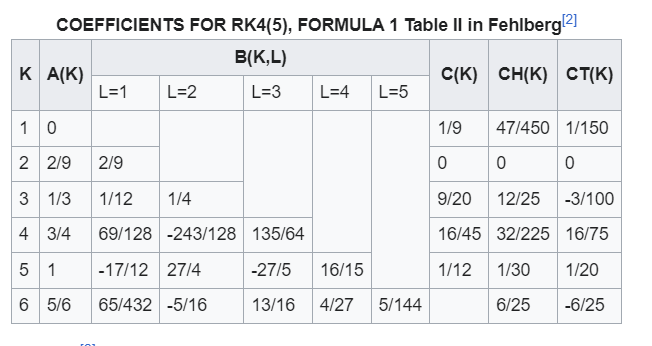

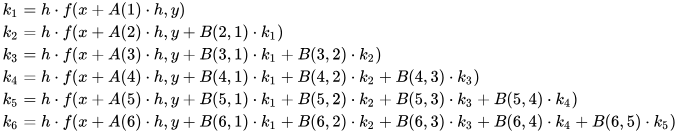

image.png

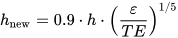

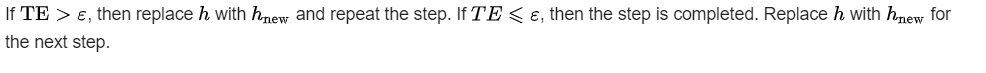

In [ ]:
def k_coeff_gen(t,A,h,A_const,B_const,a1,b1):
  k1 = h * GL(t+A_const[0]*h, A, a1, b1)
  k2 = h * GL(t+A_const[1]*h, A+B_const[1,0]*k1, a1, b1)
  k3 = h * GL(t+A_const[2]*h, A+B_const[2,0]*k1+B_const[2,1]*k2, a1, b1)
  k4 = h * GL(t+A_const[3]*h, A+B_const[3,0]*k1+B_const[3,1]*k2+B_const[3,2]*k3, a1, b1)
  k5 = h * GL(t+A_const[4]*h, A+B_const[4,0]*k1+B_const[4,1]*k2+B_const[4,2]*k3+B_const[4,3]*k4, a1, b1)
  k6 = h * GL(t+A_const[5]*h, A+B_const[5,0]*k1+B_const[5,1]*k2+B_const[5,2]*k3+B_const[5,3]*k4+B_const[5,4]*k5, a1, b1)
  return np.array([k1,k2,k3,k4,k5,k6])

def RK45(Rx,Ix,alpha,beta,dt,t_range):
  #constant definition
  h = dt/2 #step
  #GL parameters
  a1 = complex(1,alpha)
  b1 = complex(1,beta)
  #grid and time
  t = t_range[0]
  t_vec = [t]
  A_t = []
  A = A0(Rx,Ix)
  A_bar = A
  i=0
  #RK45 coefficients
  A_const = np.array([0,2/9,1/3,3/4,1,5/6])
  B_const = np.array([[None,None,None,None,None], [2/9,None,None,None,None],
                [1/12,1/4,None,None,None], [69/128,-243/128,135/64,None,None],
                 [-17/12, 27/4, -27/5, 16/15,None], [65/432, -5/16, 13/16, 4/27, 5/144]])
  CH = np.array([47/450,0,12/25,32/225,1/30,6/25])
  CT = np.array([1/150,0,-3/100,16/75,1/20,-6/25])
  while(t_range[1]>t):
    k_coeff = k_coeff_gen(t,A,h,A_const,B_const,a1,b1)
    x =np.ones_like(k_coeff)*CH[:, np.newaxis, np.newaxis]
    TE = np.abs(np.sum(CT[:, np.newaxis, np.newaxis]*k_coeff))
    if TE>dt:
      h = 0.9*h*(dt/TE)**0.2
    else:
      t=t+h
      t_vec.append(t)
      h = 0.9*h*(dt/TE)**0.2
      A += np.sum(k_coeff*CH[:, np.newaxis, np.newaxis],axis=0)
      A_t.append(A.copy())
  return (np.array(A_t),t_vec)

In [ ]:
def A0(x_real,x_imag):
  a, b = np.meshgrid(x_real,x_imag,indexing='xy')
  A = a+b
  return (A * np.exp(-0.03*(np.abs(A)**2)))

def GL(t,A,a1=1,b1=1+1.5j):
  return(a1*laplace(A) + A - b1*np.abs(A)**2*A)

def laplace(A):
  return scp.laplace(A,mode="wrap")

def heun(Rx,Ix,alpha,beta,dt,t_range,opt=0):
  if opt == 0:
    opt = 1/dt/4
  a1 = complex(1,alpha)
  b1 = complex(1,beta)
  t = t_range[0]
  A_t = []
  A = A0(Rx,Ix)
  A_bar = A
  i=0
  while(t_range[1]>t):
    dA_bar_dt = GL(t+dt,A_bar,a1,b1)
    dA_dt = GL(t,A,a1,b1)
    if (t_range[1]/opt)*i - t <= dt:
      A_t.append(A.copy())
      i+=1
    A_bar += dA_bar_dt*dt
    A += dt/2*(dA_dt+dA_bar_dt)
    t += dt
  return np.array(A_t)
def euler(Rx,Ix,alpha,beta,dt,t_range,opt=0):
  if opt == 0:
    opt = 1/dt/4
  a1 = complex(1,alpha)
  b1 = complex(1,beta)
  t = t_range[0]
  A_t = []
  A = A0(Rx,Ix)
  i=0
  while(t_range[1]>t):
    dA_dt = GL(t,A,a1,b1)
    if (t_range[1]/opt)*i - t <= dt:
      A_t.append(A.copy())
      i+=1
    A += dA_dt*dt

    t += dt
  return np.array(A_t)

def plt_A(At,t_index,title='',show=True,save=True,fname="file.jpg"):
  fig, ax = plt.subplots(1,1,figsize=(6,5))
  A = At[t_index]
  ax.set_title(title)
  ax.imshow(A)
  ax.set_ylabel("y")
  ax.set_xlabel("x")
  if save:
    fig.savefig(fname)
    #ax.save(fname)
  if show:
    fig.show()

In [ ]:
Rgrid_range = (-15,15)
Igrid_range = (-15j,15j)
grid_size = 300
Rx = np.linspace(Rgrid_range[0],Rgrid_range[1],grid_size)
Ix = np.linspace(Igrid_range[0],Igrid_range[1],grid_size)
At_RK45, t_vec = RK45(Rx,Ix,0.,1.5,1e-10,(0,10))
At_euler = euler(Rx,Ix,0.,1.5,1e-3,(0,10))
At_heun = heun(Rx,Ix,0.,1.5,1e-3,(0,10))

In [ ]:
from matplotlib.animation import FuncAnimation
def AnimatedGraph(At,show=True,save=True,filename='file.gif'):
  fig = plt.figure(figsize=(5,5))
  im = plt.imshow(At.real[0], animated=True)
  def animate(i):
      im.set_data(At.real[i])
      return im,  # the comma is needed here

  ani = FuncAnimation(fig, animate,blit=True, repeat=False, interval=1, frames=At.shape[0])
  if save:
    ani.save(filename, fps=30)
  if show:
    plt.show()

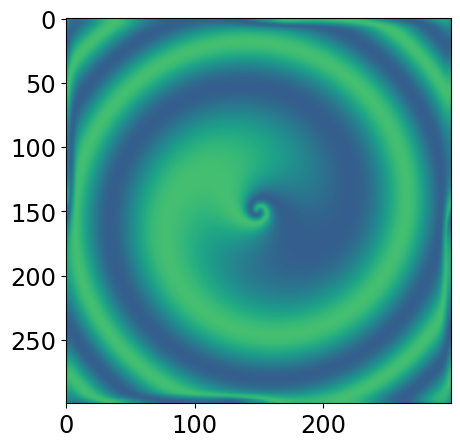

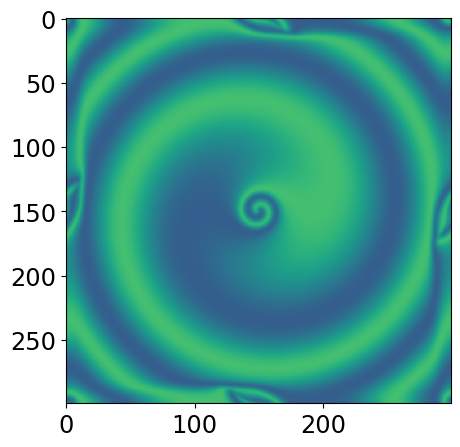

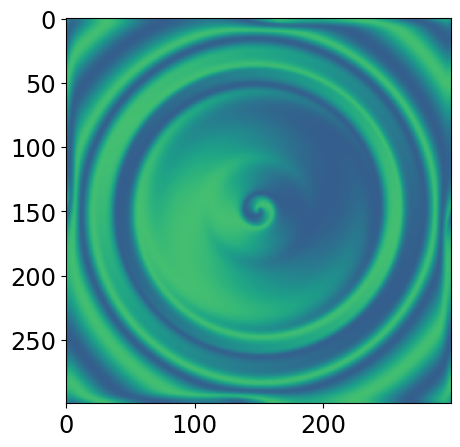

In [ ]:
AnimatedGraph(At_euler,filename="euler.gif")
AnimatedGraph(At_heun,filename="heun.gif")
AnimatedGraph(At_RK45,filename="rk45.gif")

In [ ]:
t_vec
t_half_idx = int(len(t_vec)/2)
t_half = t_vec[t_half_idx]
while np.abs(t_half-5)<1e-3:
  t_half_idx += 1
  t_half = t_vec[t_half_idx]
#index that corresponds to time = 1
t1_idx = 0
t1 = t_vec[t1_idx]
while np.abs(t1-1)<1e-3:
  t1_idx += 1
  t1 = t_vec[t1_idx]

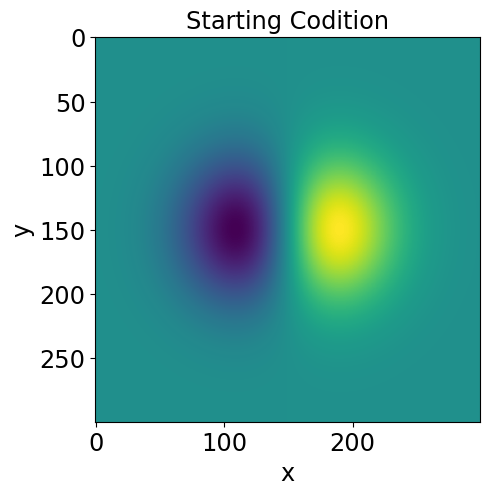

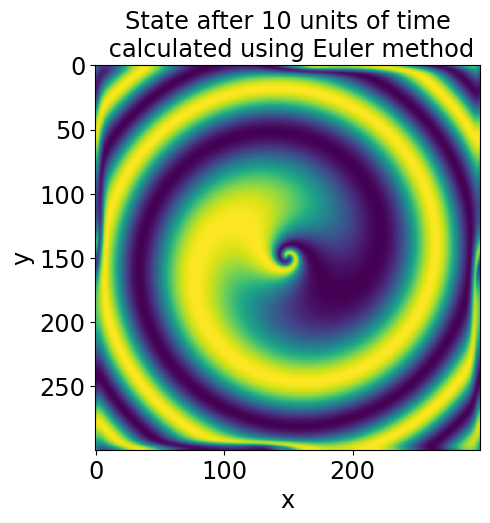

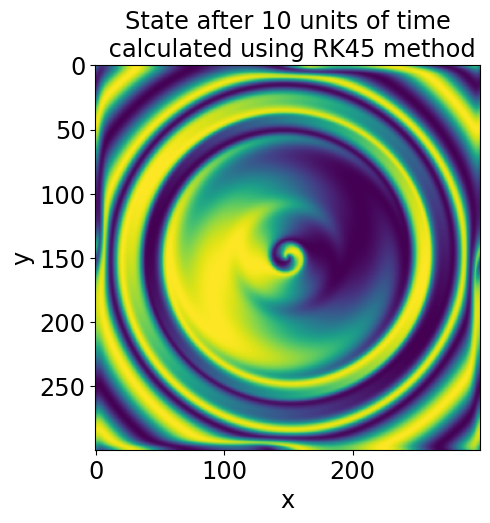

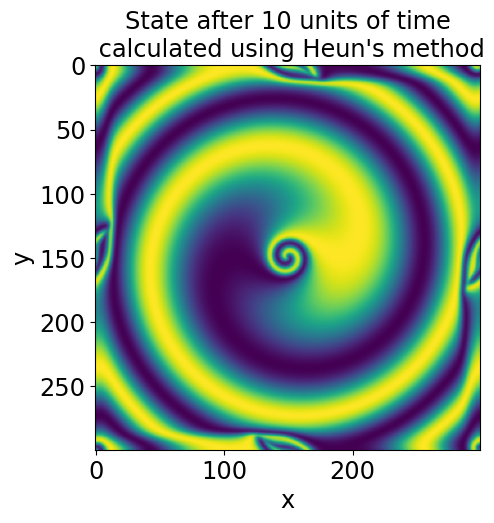

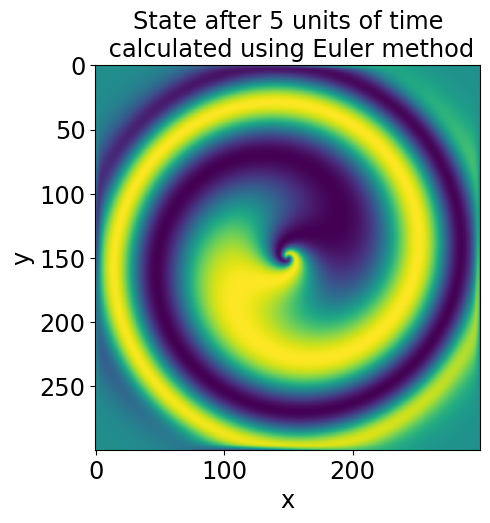

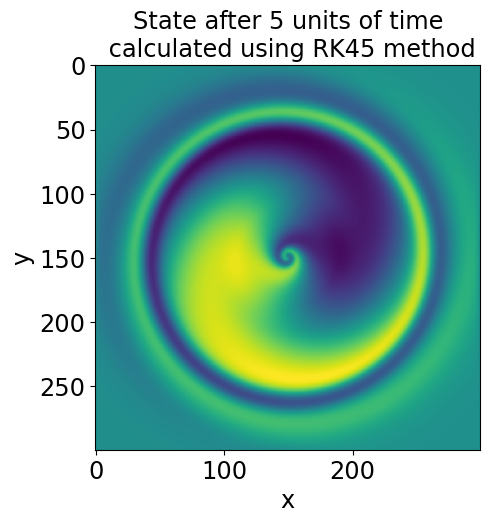

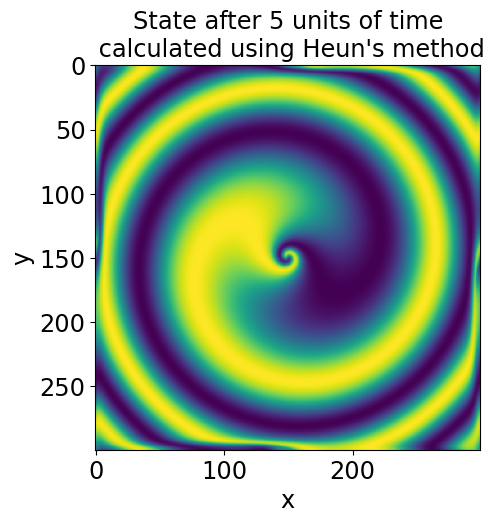

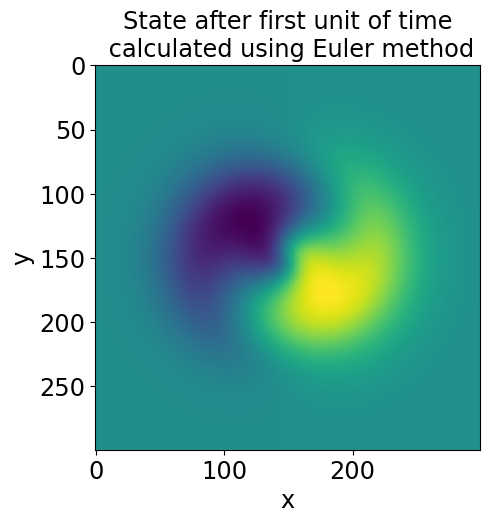

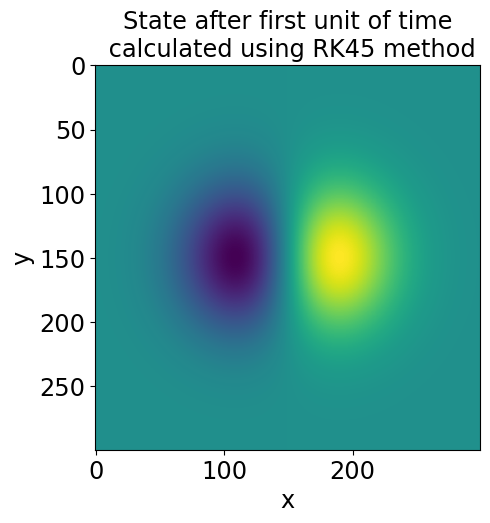

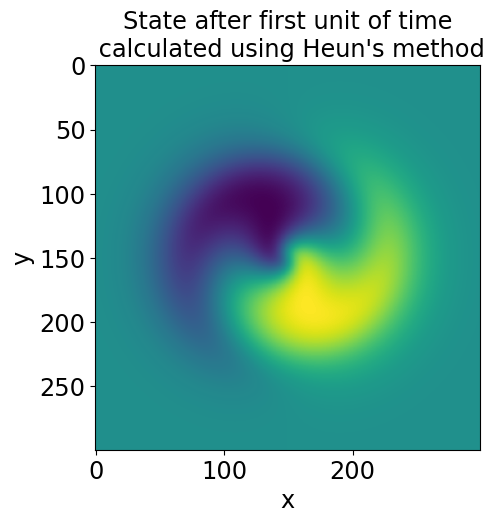

In [ ]:
plt_A(At_euler.real,0,fname="groundstate.jpg",title="Starting Codition")
plt_A(At_euler.real,-1,fname='euler_10.jpg',title="State after 10 units of time\n calculated using Euler method")
plt_A(At_RK45.real,-1,fname='RK45_10.jpg',title="State after 10 units of time\n calculated using RK45 method")
plt_A(At_heun.real,-1,fname='heun_10.jpg',title="State after 10 units of time\n calculated using Heun's method")

plt_A(At_euler.real,int(len(At_euler.real)/2),fname='euler_5.jpg',title="State after 5 units of time\n calculated using Euler method")
plt_A(At_RK45.real,t_half_idx,fname='RK45_5.jpg',title="State after 5 units of time\n calculated using RK45 method")
plt_A(At_heun.real,int(len(At_heun.real)/2),fname='heun_5.jpg',title="State after 5 units of time\n calculated using Heun's method")

idx1_e_h = 3
plt_A(At_euler.real,idx1_e_h,fname='euler_1.jpg',title="State after first unit of time\n calculated using Euler method")
plt_A(At_RK45.real,t1_idx,fname='RK45_1.jpg',title="State after first unit of time\n calculated using RK45 method")
plt_A(At_heun.real,idx1_e_h,fname='heun_1.jpg',title="State after first unit of time\n calculated using Heun's method")
